## Finetuning Convnet on Costum data

In this project, we will learn how to finetune a pretrained network on a cosstume data.<br>



By Finetuning the convnet, instead of random initializaion and training from the scratch, we initialize the network with a pretrained network, like the one that is trained on imagenet dataset. Rest of the training looks as  usual. We can select the layers that we like to finetune, it can be just the fully connected layers (fc) or other layers.
In this project we just finetune the last fc layer.


After finetuning the network, we will see the effects of distortions on our data.
Here is what we are gonna do:
1. Finetune the network for the costum data and test it on test data while our dataset dose not have any distortion (using NoDistortion Database)
2. Test the previously finetuned network on the distorted data and measure its accuracy (using the test folder in the Distortion database)
3. Finetune the network on the distorted data (using the Distortion Database) and test it on the both distorted and non-distorted test data.
4. Extra point can be achived by visualization of the layers of the network and disscussing them


Run the following commands.<br>
Hint: for running the commands in jupyter press **Shift+Ctrl**


In [1]:
# If you dont have matplotlib installed, go and install it from 
# https://matplotlib.org/users/installing.html
%matplotlib inline

In [2]:
# Importing the modules and libraries that we need in this project
# If you run the following commands and face 
# "ImportError: No module named ..." error,
# it meeans you dont have the modules and you need to install it.


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

use_gpu = False
# torch.cuda.is_available()

plt.ion()   # interactive mode

### Prepare the Data transformation for Training:

We will use torchvision and torch.utils.data packages for loading the data.<br>
The problem we're going to solve today is to train a model to classify 4 a dataset with 4 classes, namely, C1, C2, C3, and C4.



In [3]:
# Here we define the transformation that we would like to 
# apply on our images in our database.
# For training we have traning and validation datasets
# We resize the images to 256x256 to increase the speed

Images_Size=  300;
batch_size=2;

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(Images_Size),
        transforms.CenterCrop(Images_Size),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Scale(Images_Size),
        transforms.CenterCrop(Images_Size),
        transforms.ToTensor()
    ]),
}

## Loading the training Data:

In [4]:
# Here we choose the data directory that we like to 
# finetune our network on
# In this example we choose the dataset with no distortion
#  If you need to finetune the network on another dataset,
# you may need to change the data_dir

data_dir = 'ProjectDatabase/Train_NoDistortion'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size,
                                               shuffle=True, num_workers=2)
                for x in ['train', 'val']}
# In the following we choose batch_size = 4, 
# it means in the traning, each time we feed 
# the network with 4 images
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

In [5]:

data_dir = 'ProjectDatabase/Train_NoDistortion'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size,
                                               shuffle=True, num_workers=2)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}


In [6]:
classes_names = dsets['train'].classes
print('Name of the classes:' '%s' % classes_names)

Name of the classes:['Airplane', 'Bear', 'Elk', 'Faces', 'Pot', 'Watch']


Let's visualize a few of the training images understand our data.

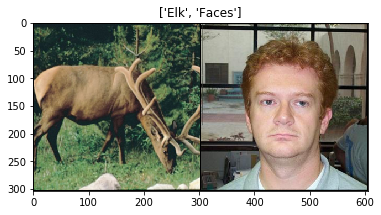

In [7]:
# Making a fuction to show the images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

## Training the model


Now, let's write a general function to train a model. 

In [8]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

Let's create our learning rate scheduler. We will exponentially decrease the learning rate once every few epochs.



In [9]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [10]:
dset_classes = dsets['train'].classes

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Finetuning the convnet:

Here we load a pretrained model and retrain the final fully connected layer.
Here we are using the resnet.
There are lots of materials online regarding the To learn more about the resnet you can read the following paper.
"Deep Residual Learning for Image Recognition".<br>
In the following we finetune the last two layers of resnet.
We change the last layer (that represets the number of classes) to 4, which is number of our classes, and also finetune the fully connected layer before that.



In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
Num_of_Classes=len(dsets['train'].classes);
model_ft.fc = nn.Linear(num_ftrs, Num_of_Classes)

# Loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

### Train and evaluate
Lets train the network. <br>
It should take around  30mins to 5 hours on CPU, depending on your system hardware.




In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
LR is set to 0.001
train Loss: 0.4613 Acc: 0.6958
val Loss: 0.0586 Acc: 0.9750

Epoch 1/4
----------
train Loss: 0.0602 Acc: 0.9625
val Loss: 0.0238 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.0254 Acc: 0.9875
val Loss: 0.0165 Acc: 0.9917

Epoch 3/4
----------
train Loss: 0.0202 Acc: 0.9792
val Loss: 0.0529 Acc: 0.9750

Epoch 4/4
----------
train Loss: 0.0127 Acc: 0.9958
val Loss: 0.0199 Acc: 0.9917

Training complete in 6m 16s
Best val Acc: 1.000000


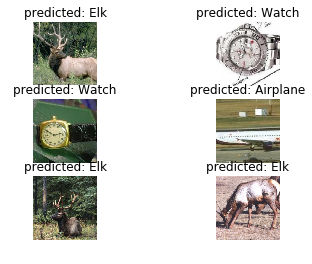

In [13]:
visualize_model(model_ft)

## Testing 
Now lets test our trained model on the testing data, the testing data can be chosen from the NoDistortion folder or even the distortion folder.

In [14]:
# Data transformation

data_transforms_Test = {
    'test': transforms.Compose([
        transforms.Scale(Images_Size),
        transforms.CenterCrop(Images_Size),
        transforms.ToTensor()
    ]),
}


GroundTruthLables = ('Airplane', 'Bear', 'Elk', 'Faces',
           'PC', 'Pot', 'Watch')

In [15]:
# The address of our testing data

data_dir_Test = 'ProjectDatabase/Train_NoDistortion'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir_Test, x), data_transforms_Test[x])
         for x in ['test']}
dset_loaders_test = {x: torch.utils.data.DataLoader(dsets[x], batch_size,
                                               shuffle=True, num_workers=2)
                for x in ['test']}
# In the following we choose batch_size = 4, 
# it means in the traning, each time we feed 
# the network with 4 images
dset_sizes = {x: len(dsets[x]) for x in ['test']}
dset_classes = dsets['test'].classes

print(dset_sizes)

{'test': 180}


Lets illustrate some testing results

GroundTruth:    Elk   Pot


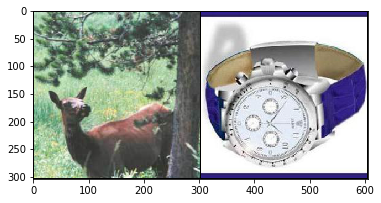

In [16]:

# Get a batch of training data
inputs, lables = next(iter(dset_loaders_test['test']))

# Make a grid from batch
imshow(torchvision.utils.make_grid(inputs))
print('GroundTruth: ', ' '.join('%5s' 
                                % GroundTruthLables[lables[j]] 
                                for j in range(batch_size)))


Okay, now let us see what the neural network thinks these examples above are:


In [17]:
# Testing process
outputs = model_ft(Variable(inputs))


In [18]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % GroundTruthLables[predicted[j]]
                              for j in range(batch_size)))




Predicted:    Elk   Pot


In [19]:
# Measuring the accuracy:
      
correct = 0
total = 0
for data in dset_loaders_test['test']:
    images, labels = data
    outputs = model_ft(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 97 %


In [20]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

for data in dset_loaders_test['test']:
    images, labels = data
    outputs = model_ft(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
#     print(labels)
    for i in range(batch_size):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
for i in range(Num_of_Classes):
    print('Accuracy of %5s : %2d %%' % (
        GroundTruthLables[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Airplane : 100 %
Accuracy of  Bear : 93 %
Accuracy of   Elk : 100 %
Accuracy of Faces : 100 %
Accuracy of    PC : 93 %
Accuracy of   Pot : 100 %
